### Goal setting

The goal of this project is to analyze sales trends and patterns to generate actionable business insights and accurately forecast future sales


### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Collect data

In [4]:
df=pd.read_csv('store_sales.csv')

In [5]:
df

,date,sales,promo,holiday
0,01-01-2022,184.78,0,0
1,02-01-2022,192.62,0,0
2,03-01-2022,212.68,0,0
3,04-01-2022,249.58,1,0
4,05-01-2022,223.50,0,0
...,...,...,...,...
725,27-12-2023,290.81,1,0
726,28-12-2023,251.68,0,0
727,29-12-2023,259.94,1,0
728,30-12-2023,217.98,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     730 non-null    object 
 1   sales    730 non-null    float64
 2   promo    730 non-null    int64  
 3   holiday  730 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 22.9+ KB


### Data cleaning

In [7]:
df.isna().sum()

date       0
sales      0
promo      0
holiday    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

No null values and duplicates found.

### Feature engineering

In [9]:
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")

In [10]:
df = df.set_index(df['date'])

### EDA

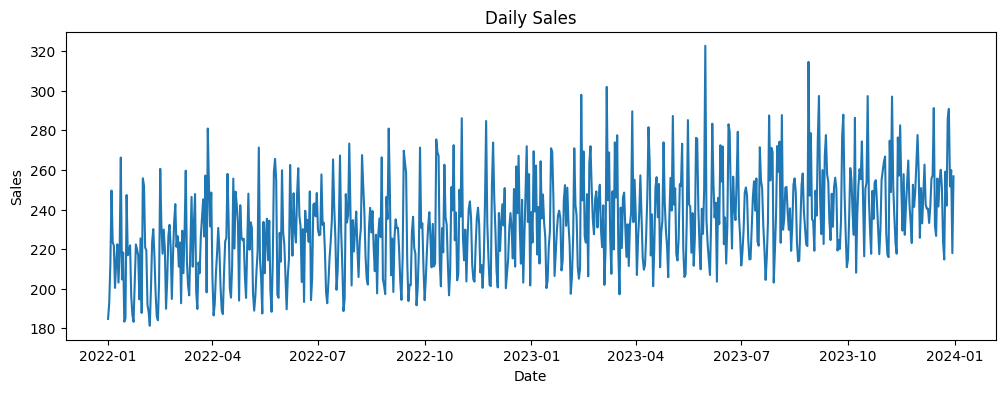

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df['sales'])
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

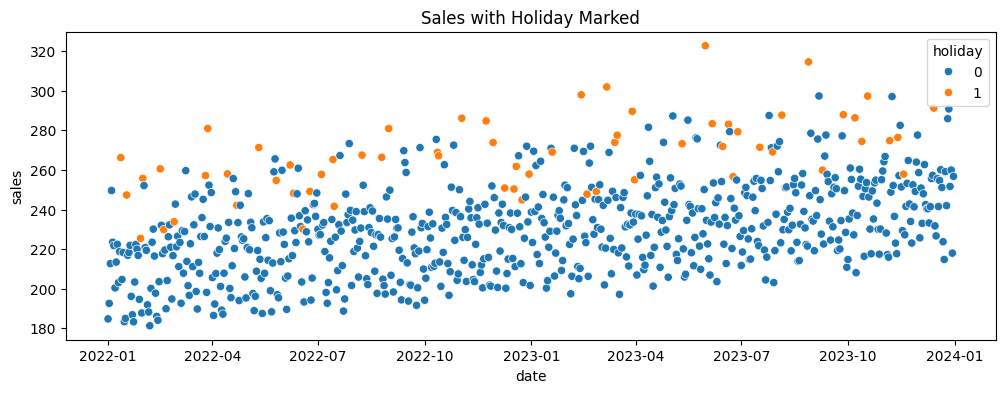

In [12]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df.index, y=df['sales'],hue=df['holiday'])
plt.title("Sales with Holiday Marked")
plt.show()


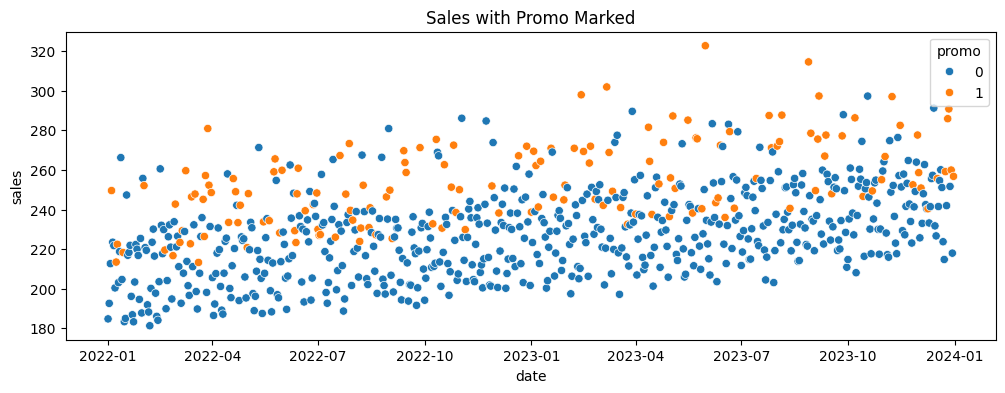

In [13]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df.index, y=df['sales'],hue=df['promo'])
plt.title("Sales with Promo Marked")
plt.show()

### Time-Series Decomposition Analysis

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

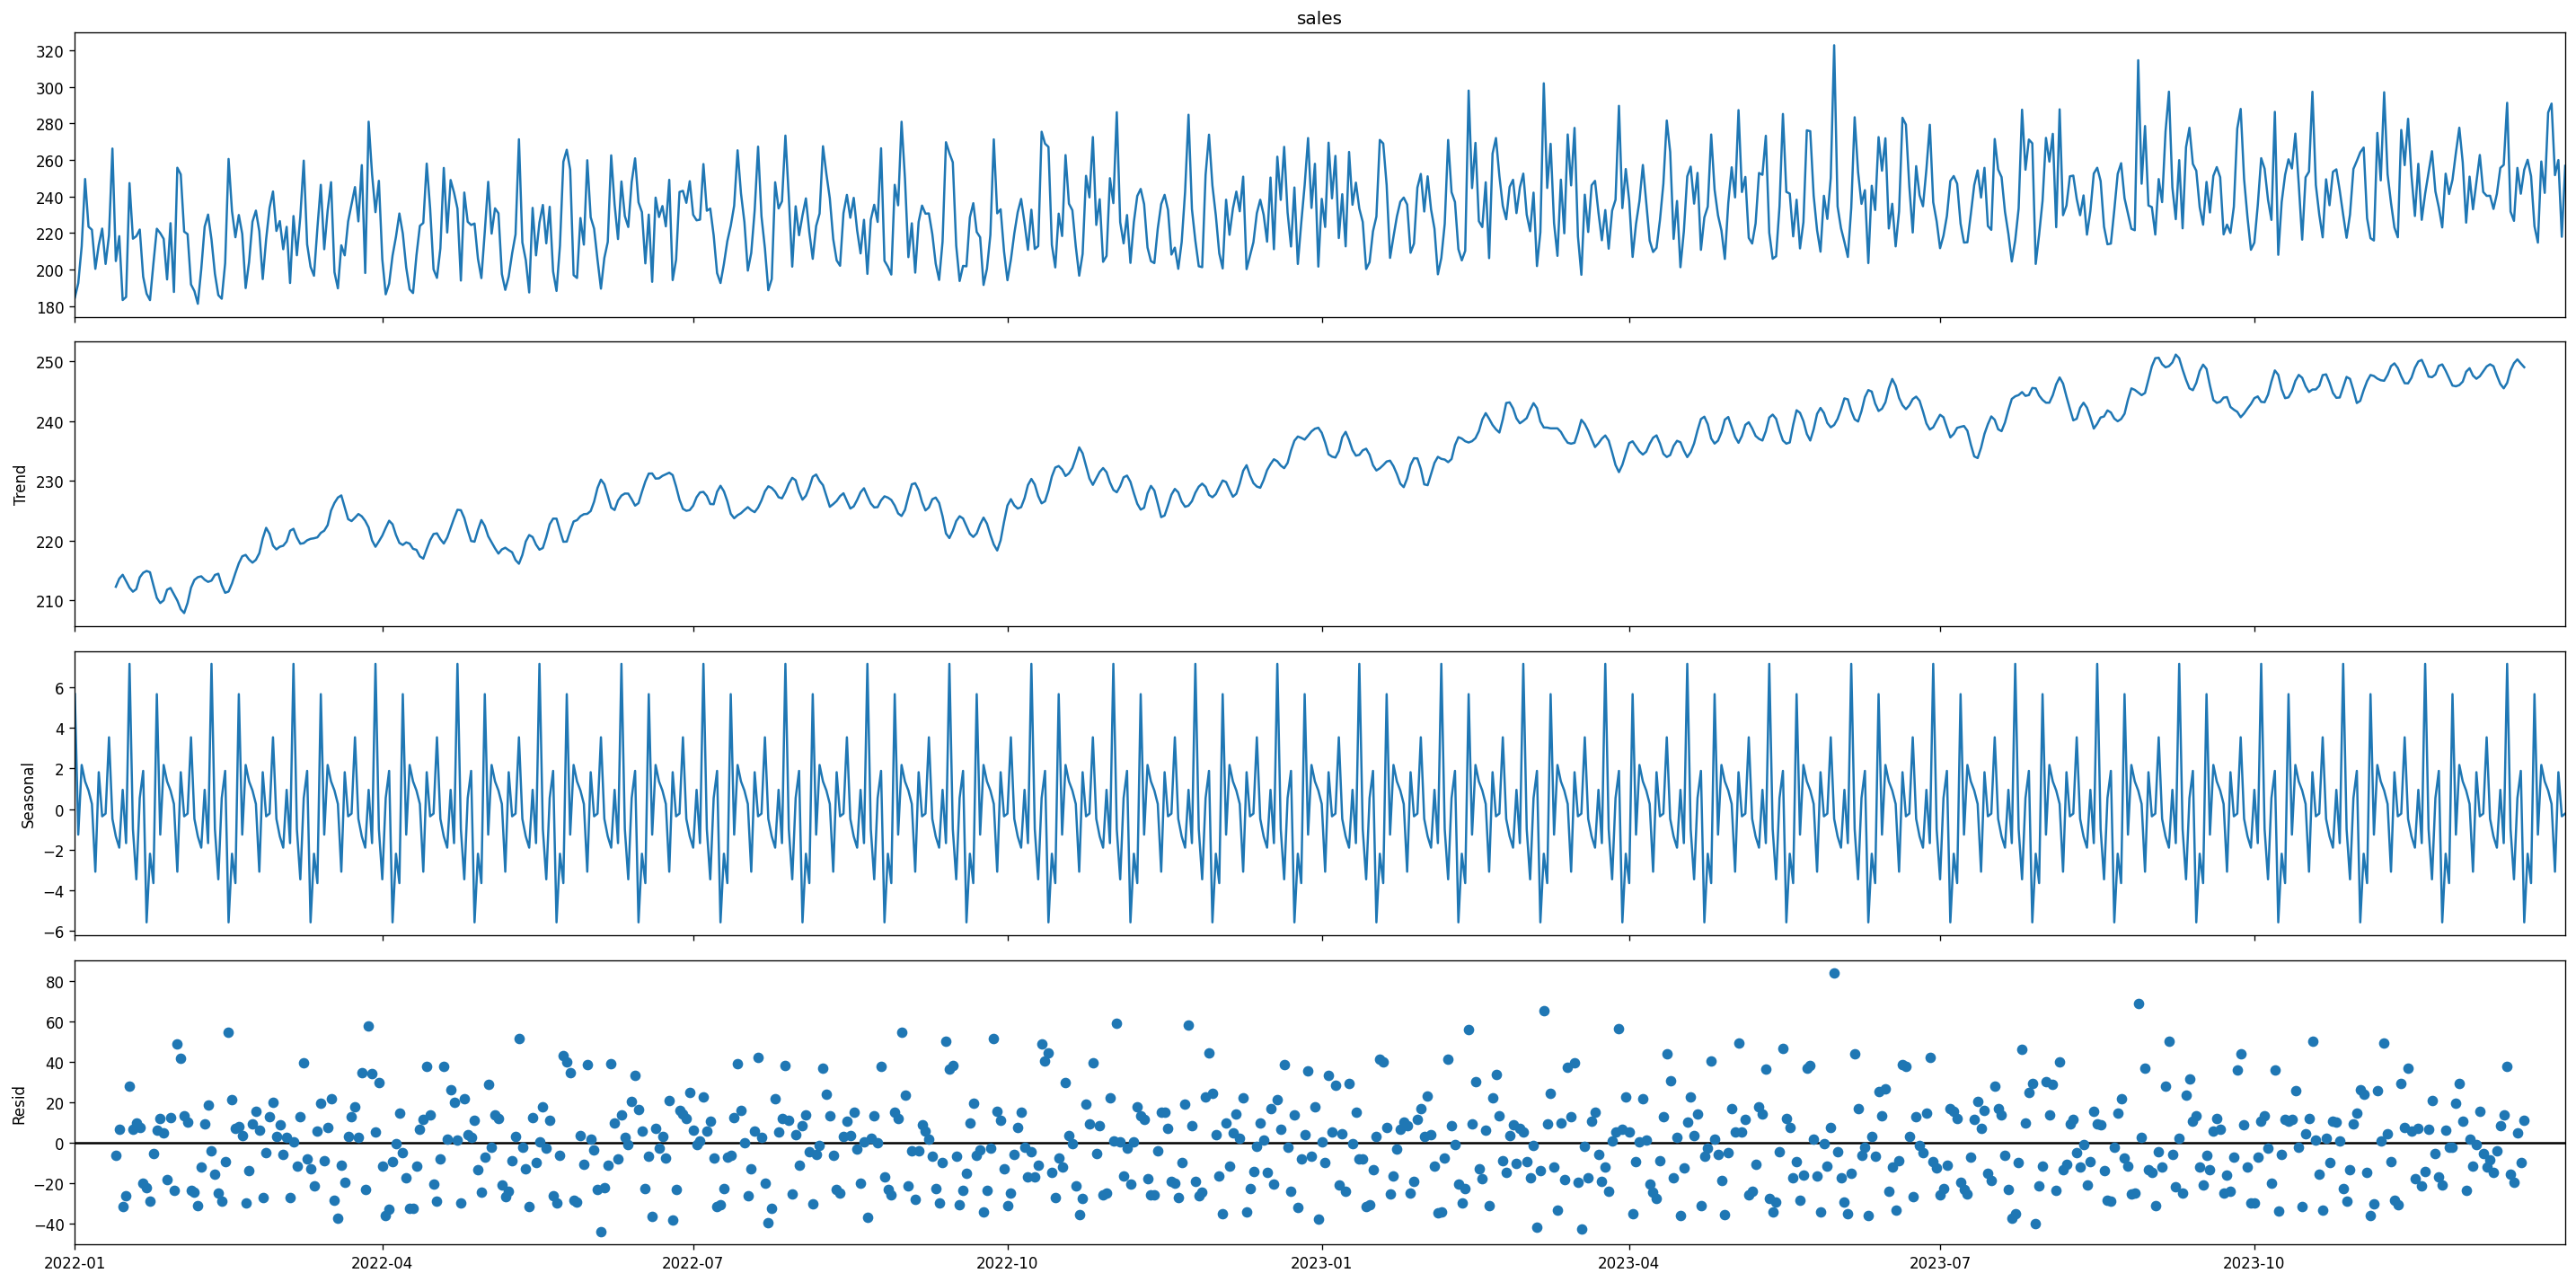

In [15]:
result = seasonal_decompose(df['sales'], model='additive', period=24)
fig=result.plot()
fig.set_size_inches(24,12)
fig.set_dpi(120)
plt.tight_layout()
plt.show()

### ADFuller Stationarity Test

In [16]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['sales'])
print('ADF stat', result[0])
print('p value', result[1])

ADF stat -1.9159934205020233
p value 0.3245751087373079


In [17]:
d1=np.diff(df['sales'])
result=adfuller(d1)
print('ADF stat', result[0])
print('p value', result[1])

ADF stat -10.976790871962004
p value 7.63394798006549e-20


p<0.05 hence data is seasonal and showing trend, so we can build ARIMA model here.

### Train test split

In [18]:
split_point = int(len(df) * 0.8)
train= df.iloc[:split_point]
test= df.iloc[split_point:]


In [19]:
train.shape

(584, 4)

In [20]:
test.shape

(146, 4)

### Model building

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [22]:
model = SARIMAX(
        train['sales'],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1,7),
        exog=train[['holiday', 'promo']],
        enforce_stationarity=False,
        enforce_invertibility=False
    )

c:\Users\vinus\.vscode\Data Science\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\vinus\.vscode\Data Science\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [23]:
model_fit = model.fit(disp=False)

c:\Users\vinus\.vscode\Data Science\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
forecast = model_fit.predict(
        start=test.index[0],
        end=test.index[-1],
        exog=test[['holiday', 'promo']]
    )

In [25]:
forecast_train = model_fit.predict(
        start=train.index[0],
        end=train.index[-1],
        exog=train[['holiday', 'promo']]
    )

In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def evalution(forecast,test):
    mse  = mean_squared_error(test['sales'], forecast)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(test['sales'], forecast)
    r2   = r2_score(test['sales'], forecast)
    print("SARIMAX Results:")
    print("MSE :", mse)
    print("RMSE:", rmse)
    print("MAE :", mae)
    print("R2  :", r2)


## Model Evaluation

In [27]:
evalution(forecast,test)

SARIMAX Results:
MSE : 25.140491767798515
RMSE: 5.014029494109355
MAE : 3.9759109852228955
R2  : 0.9417679279660415


| Metric   | Score | Insight      |
| -------- | ----- | ------------ |
| **MSE**  | 25.14 | **Low**      |
| **RMSE** | 5.01  | **Good**     |
| **MAE**  | 3.98  | **Accurate** |
| **R²**   | 0.94  | **Strong**   |



SARIMAX captures trend, seasonality, and temporal patterns effectively, resulting in stable and reliable forecasts.

Low error values (RMSE ≈ 5.01, MAE ≈ 3.98) show that the model predicts very close to actual values.

High R² (≈ 0.94) indicates the model explains most of the variation in the time-series, demonstrating a strong overall fit.

In [28]:
train.shape

(584, 4)

In [29]:
evalution(forecast_train,train)

SARIMAX Results:
MSE : 119.93528865511603
RMSE: 10.951497096521372
MAE : 4.674446225944749
R2  : 0.7844697483309439


#### Overfit checking

**Comparision between Train and Test set performance**

| **Metric** | **Train** | **Test** |
| ---------- | --------- | -------- |
| **MSE**    | 119.9353  | 25.1405  |
| **RMSE**   | 10.9515   | 5.0140   |
| **MAE**    | 4.6744    | 3.9759   |
| **R²**     | 0.7845    | 0.9418   |


SARIMAX is performing very well on the test set.

No overfitting is observed.

The model captures trends/seasonality effectively.


## Hyperparameter Tuning

In [30]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

y = train['sales']
exog = train[['holiday', 'promo']]


p = d = q = range(0, 3)     
P = D = Q = range(0, 3)     
s = 7                         


pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

print("Searching best parameters...")

for order in pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(
                y,
                order=order,
                seasonal_order=(s_order[0], s_order[1], s_order[2], s),
                exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal_order = (s_order[0], s_order[1], s_order[2], s)

            print(f"Checked SARIMAX{order}x{(s_order[0], s_order[1], s_order[2], s)} - AIC:{result.aic}")

        except:
            continue

print("\nBest Model Found:")
print("Order (p,d,q) =", best_order)
print("Seasonal Order (P,D,Q,s) =", best_seasonal_order)
print("Best AIC =", best_aic)


Searching best parameters...
Checked SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:7756.840425861274
Checked SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:7111.217587818892
Checked SARIMAX(0, 0, 0)x(0, 0, 2, 7) - AIC:6418.299231683064
Checked SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:3879.7568344752954
Checked SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:3552.15764089155
Checked SARIMAX(0, 0, 0)x(0, 1, 2, 7) - AIC:3510.384630801368
Checked SARIMAX(0, 0, 0)x(0, 2, 0, 7) - AIC:4451.636853000262
Checked SARIMAX(0, 0, 0)x(0, 2, 1, 7) - AIC:3805.408080955148
Checked SARIMAX(0, 0, 0)x(0, 2, 2, 7) - AIC:3434.7963477626085
Checked SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:3886.9126308600985
Checked SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:5457.0477436922065
Checked SARIMAX(0, 0, 0)x(1, 0, 2, 7) - AIC:5669.200091918986
Checked SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:3673.6534723412565
Checked SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:3560.0218982139986
Checked SARIMAX(0, 0, 0)x(1, 1, 2, 7) - AIC:3511.9868162168295
Checked SARIMAX(0, 0, 0)x(1, 2, 0, 

In [31]:
best_model = SARIMAX(
    train['sales'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    exog=train[['holiday', 'promo']],
    enforce_stationarity=False,
    enforce_invertibility=False
)



In [32]:
best_model_fit = best_model.fit(disp=False)

In [33]:
upd_forecast = best_model_fit.predict(
        start=test.index[0],
        end=test.index[-1],
        exog=test[['holiday', 'promo']])

In [34]:
evalution(upd_forecast,test)

SARIMAX Results:
MSE : 25.15911260000644
RMSE: 5.015886023426613
MAE : 3.979207450492323
R2  : 0.9417247971612633


| Metric | Before Tuning | After Tuning | Observation                                     |
| ------ | ------------- | ------------ | ----------------------------------------------- |
| MSE    | 25.14         | 25.16        | Negligible change, model error almost same      |
| RMSE   | 5.01          | 5.02         | Minimal difference, forecasting accuracy stable |
| MAE    | 3.98          | 3.98         | Slight increase, not significant                |
| R²     | 0.9418        | 0.9417       | Model still explains ~94% of variance           |


SARIMAX hyperparameter tuning showed minimal impact. MSE, RMSE, MAE, and R² remained almost unchanged, indicating the original model was already well-optimized

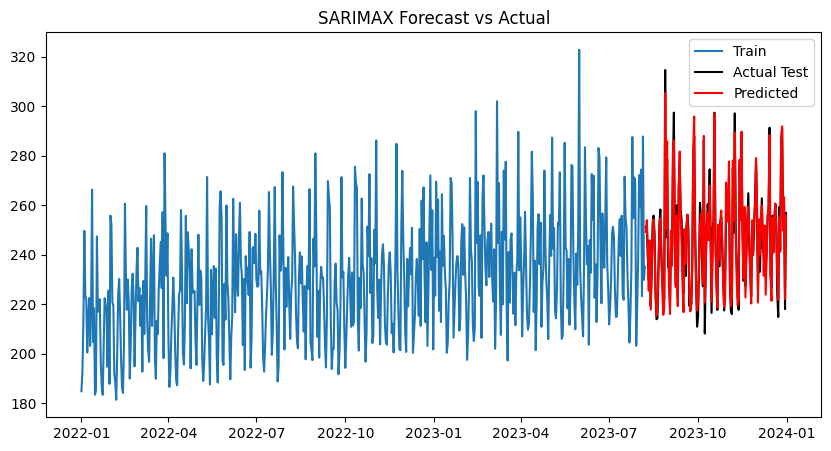

In [35]:
plt.figure(figsize=(10,5))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Actual Test', color='black')
plt.plot(forecast, label='Predicted', color='red')
plt.title("SARIMAX Forecast vs Actual")
plt.legend()
plt.show()

The SARIMAX model closely follows the trend and seasonality of the actual test data, indicating strong predictive stability.

**Sarimax and XGBoost comparision**

| **Metric** | **SARIMAX** | **XGBoost** | **Better Model** |
| ---------- | ------------------ | ------------------------ | ---------------- |
| **MSE**    | **25.1405**        | 40.7915                  | **SARIMAX**      |
| **RMSE**   | **5.0140**         | 6.3868                   | **SARIMAX**      |
| **MAE**    | **3.9759**         | 4.9088                   | **SARIMAX**      |
| **R²**     | **0.9418**         | 0.9076                   | **SARIMAX**      |


## Conclusion

SARIMAX model provided the best fit for this sales dataset, effectively capturing trends and weekly seasonality. 
The sales analysis further revealed actionable insights on demand patterns, promotions, and store performance, supporting stronger data-driven decisions.
